    AMRUTHA KANAKATTE RAVISHANKAR
    CWID :20027346
    Homework 04: Machine Reading Comprehension


#**Machine Reading Comprehension**



In [3]:
#Installing required libraries
!pip install transformers datasets

In [26]:
!pip install transformers torch

In [27]:
#Importing required libraries
from datasets import load_dataset
import pandas as pd
from transformers import RobertaForQuestionAnswering, RobertaTokenizer
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

#**1. Data Preparation**

##**1.1 Data Downloading and Preprocessing**

In [5]:
# Download the SQuAD2.0 dataset
dataset = load_dataset("squad_v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [15]:
# Select 15 samples
selected_data = dataset['train'][:15]
selected_data

{'id': ['56be85543aeaaa14008c9063',
  '56be85543aeaaa14008c9065',
  '56be85543aeaaa14008c9066',
  '56bf6b0f3aeaaa14008c9601',
  '56bf6b0f3aeaaa14008c9602',
  '56bf6b0f3aeaaa14008c9603',
  '56bf6b0f3aeaaa14008c9604',
  '56bf6b0f3aeaaa14008c9605',
  '56d43c5f2ccc5a1400d830a9',
  '56d43c5f2ccc5a1400d830aa',
  '56d43c5f2ccc5a1400d830ab',
  '56d43c5f2ccc5a1400d830ac',
  '56d43c5f2ccc5a1400d830ad',
  '56d43ce42ccc5a1400d830b4',
  '56d43ce42ccc5a1400d830b5'],
 'title': ['Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé',
  'Beyoncé'],
 'context': ['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Dest

##**1.2 Data Statistics**

In [19]:
# Statistics about the context length
context_lengths = [len(item.split()) for item in selected_data['context']]
max_context_length = max(context_lengths)
min_context_length = min(context_lengths)
avg_context_length = round(sum(context_lengths) / len(context_lengths), 0)

In [20]:
# Statistics about the question length
question_lengths = [len(item.split()) for item in selected_data["question"]]
max_question_length = max(question_lengths)
min_question_length = min(question_lengths)
avg_question_length = round(sum(question_lengths) / len(question_lengths), 0)

In [22]:
# Statistics about the answer length
answer_lengths = [len(item['text'][0].split()) for item in selected_data['answers']]
max_answer_length = max(answer_lengths)
min_answer_length = min(answer_lengths)
avg_answer_length = round(sum(answer_lengths) / len(answer_lengths), 0)

In [25]:
# Statistics table
table = {
    'Type': ['Context', 'Question', 'Answer'],
    'MaxLength': [max_context_length, max_question_length, max_answer_length],
    'MinLength': [min_context_length, min_question_length, min_answer_length],
    'AvgLength': [avg_context_length, avg_question_length, avg_answer_length]
}

statistics_table = pd.DataFrame(table)
print(statistics_table)

       Type  MaxLength  MinLength  AvgLength
0   Context        109        109      109.0
1  Question         12          6        8.0
2    Answer          4          1        2.0


Inference: Given that these 15 question-answer pairs are from the same context, the table shows that the maximum, lowest, and average duration of the context are all the same.

#2. Question Answering

## **2.1 Use the pre-trained RoBERTa model to solve the question answering task on the data**

In [28]:
model_name = "deepset/roberta-base-squad2"
model = RobertaForQuestionAnswering.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [34]:
# Loop through each data sample
for i in range(15):
    context = selected_data['context'][i]
    question = selected_data['question'][i]

    inputs = tokenizer.encode_plus(
        question, context, add_special_tokens=True, return_tensors="pt", truncation=True, padding=True
    )
    with torch.no_grad():
        outputs = model(**inputs)
    answer_start_index = torch.argmax(outputs.start_logits)
    answer_end_index = torch.argmax(outputs.end_logits)
    if answer_end_index < answer_start_index:
        answer_end_index = answer_start_index
    predicted_answer_tokens = inputs['input_ids'][0, answer_start_index: answer_end_index + 1]
    decoded_answer = tokenizer.decode(predicted_answer_tokens, skip_special_tokens=True)

    print(f"Sample {i + 1}:")
    print(f"Question: {question}")
    print(f"Answer Start Index: {answer_start_index}, Answer End Index: {answer_end_index}")
    print(f"Predicted Answer Tokens: {predicted_answer_tokens}")
    print(f"Decoded Answer: {decoded_answer}")
    print()

Sample 1:
Question: When did Beyonce start becoming popular?
Answer Start Index: 87, Answer End Index: 89
Predicted Answer Tokens: tensor([ 628, 4525,   29])
Decoded Answer:  late 1990s

Sample 2:
Question: What areas did Beyonce compete in when she was growing up?
Answer Start Index: 78, Answer End Index: 80
Predicted Answer Tokens: tensor([6970,    8, 7950])
Decoded Answer:  singing and dancing

Sample 3:
Question: When did Beyonce leave Destiny's Child and become a solo singer?
Answer Start Index: 155, Answer End Index: 155
Predicted Answer Tokens: tensor([35153])
Decoded Answer: 2003

Sample 4:
Question: In what city and state did Beyonce  grow up? 
Answer Start Index: 72, Answer End Index: 72
Predicted Answer Tokens: tensor([1184])
Decoded Answer:  Texas

Sample 5:
Question: In which decade did Beyonce become famous?
Answer Start Index: 89, Answer End Index: 90
Predicted Answer Tokens: tensor([4525,   29])
Decoded Answer:  1990s

Sample 6:
Question: In what R&B group was she the l

## **2.2 Design the prompts to interact with ChatGPT and solve the question answering task on the data**

### **Prompt Template for ChatGPT about the selected N question-answer pairs**

Context: "context"

Question 1: "question 1"

Question 2: "question 2"

Question N: "question N"

Please provide the short answer to each question about the context, and also an explanation of the reasoning for that answer.

###**Prompt to ChatGPT**
**CONTEXT:** Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

**Questions:**

Question 1: When did Beyonce start becoming popular?

Question 2: What areas did Beyonce compete in when she was growing up?

Question 3: When did Beyonce leave Destiny's Child and become a solo singer?

Question 4: In what city and state did Beyonce  grow up?

Question 5: In which decade did Beyonce become famous?

Question 6: In what R&B group was she the lead singer?

Question 7: What album made her a worldwide known artist?

Question 8: Who managed the Destiny's Child group?

Question 9: When did Beyoncé rise to fame?

Question 10: What role did Beyoncé have in Destiny's Child?

Question 11: What was the first album Beyoncé released as a solo artist?

Question 12: When did Beyoncé release Dangerously in Love?

Question 13: How many Grammy awards did Beyoncé win for her first solo album?

Question 14: What was Beyoncé's role in Destiny's Child?

Question 15: What was the name of Beyoncé's first solo album?

Please provide the short answer to each question about the context, and also an explanation of the reasoning for that answer.

### **ChatGPT's outputs:**

**Q1:** **When did Beyoncé start becoming popular?**  
**Answer:** Late 1990s.  
**Reasoning:** Beyoncé rose to fame as the lead singer of Destiny's Child, which became popular in the late 1990s.

---

**Q2:** **What areas did Beyoncé compete in when she was growing up?**  
**Answer:** Singing and dancing.  
**Reasoning:** The context states that as a child, she participated in various singing and dancing competitions.

---

**Q3:** **When did Beyoncé leave Destiny's Child and become a solo singer?**  
**Answer:** Early 2000s.  
**Reasoning:** Beyoncé released her debut solo album *Dangerously in Love* in 2003, indicating her transition to a solo career occurred around this time, during a Destiny's Child hiatus.

---

**Q4:** **In what city and state did Beyoncé grow up?**  
**Answer:** Houston, Texas.  
**Reasoning:** The context explicitly mentions that Beyoncé was "born and raised in Houston, Texas."

---

**Q5:** **In which decade did Beyoncé become famous?**  
**Answer:** 1990s.  
**Reasoning:** Beyoncé rose to fame as part of Destiny's Child in the late 1990s.

---

**Q6:** **In what R&B group was she the lead singer?**  
**Answer:** Destiny's Child.  
**Reasoning:** The context states that Beyoncé was the lead singer of the R&B girl group Destiny's Child.

---

**Q7:** **What album made her a worldwide known artist?**  
**Answer:** *Dangerously in Love.*  
**Reasoning:** The context states that this album established her as a solo artist worldwide.

---

**Q8:** **Who managed the Destiny's Child group?**  
**Answer:** Mathew Knowles.  
**Reasoning:** The context states that Beyoncé's father, Mathew Knowles, managed the group.

---

**Q9:** **When did Beyoncé rise to fame?**  
**Answer:** Late 1990s.  
**Reasoning:** Beyoncé's fame began as the lead singer of Destiny's Child, which rose to prominence in the late 1990s.

---

**Q10:** **What role did Beyoncé have in Destiny's Child?**  
**Answer:** Lead singer.  
**Reasoning:** The context explicitly mentions that Beyoncé was the lead singer of the group.

---

**Q11:** **What was the first album Beyoncé released as a solo artist?**  
**Answer:** *Dangerously in Love.*  
**Reasoning:** The context states that her debut album was *Dangerously in Love.*

---

**Q12:** **When did Beyoncé release *Dangerously in Love*?**  
**Answer:** 2003.  
**Reasoning:** The context mentions that this album was released in 2003.

---

**Q13:** **How many Grammy Awards did Beyoncé win for her first solo album?**  
**Answer:** Five.  
**Reasoning:** The context specifies that *Dangerously in Love* earned her five Grammy Awards.

---

**Q14:** **What was Beyoncé's role in Destiny's Child?**  
**Answer:** Lead singer.  
**Reasoning:** The context explicitly states this role.

---

**Q15:** **What was the name of Beyoncé's first solo album?**  
**Answer:** *Dangerously in Love.*  
**Reasoning:** The context directly mentions that this was her debut solo album.

##**2.3 Design the prompts to interact with Claude 3.5 Sonnet and solve the question answering task on the data**

### **Prompt Template for ChatGPT about the selected N question-answer pairs (Same as 2.2)**

Context: "context"

Question 1: "question 1"

Question 2: "question 2"

Question N: "question N"

Please provide the short answer to each question about the context, and also an explanation of the reasoning for that answer.

###**Interaction with Claude 2 about the selected 15 question-answer pairs**

**CONTEXT:** Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

**Questions:**

Question 1: When did Beyonce start becoming popular?

Question 2: What areas did Beyonce compete in when she was growing up?

Question 3: When did Beyonce leave Destiny's Child and become a solo singer?

Question 4: In what city and state did Beyonce  grow up?

Question 5: In which decade did Beyonce become famous?

Question 6: In what R&B group was she the lead singer?

Question 7: What album made her a worldwide known artist?

Question 8: Who managed the Destiny's Child group?

Question 9: When did Beyoncé rise to fame?

Question 10: What role did Beyoncé have in Destiny's Child?

Question 11: What was the first album Beyoncé released as a solo artist?

Question 12: When did Beyoncé release Dangerously in Love?

Question 13: How many Grammy awards did Beyoncé win for her first solo album?

Question 14: What was Beyoncé's role in Destiny's Child?

Question 15: What was the name of Beyoncé's first solo album?

Please provide the short answer to each question about the context, and also an explanation of the reasoning for that answer.

### **Claude 3.5 Sonnet's outputs:**

1. When did Beyonce start becoming popular?

Answer: Late 1990s

Reasoning: The context explicitly states she "rose to fame in the late 1990s" as the lead singer of Destiny's Child.

2. What areas did Beyonce compete in when she was growing up?

Answer: Singing and dancing

Reasoning: The context directly states she "performed in various singing and dancing competitions as a child."

3. When did Beyonce leave Destiny's Child and become a solo singer?

Answer:  Around 2003

Reasoning: The text mentions that during the group's hiatus, she released her debut solo album in 2003.

4. In what city and state did Beyonce grow up?

Answer: Houston, Texas

Reasoning: The context explicitly states she was "born and raised in Houston, Texas."

5. In which decade did Beyonce become famous?

Answer: 1990s

Reasoning: The context states she "rose to fame in the late 1990s."

6. In what R&B group was she the lead singer?

Answer: Destiny's Child

Reasoning: The context directly states she was "lead singer of R&B girl-group Destiny's Child."

7. What album made her a worldwide known artist?

Answer: Dangerously in Love

Reasoning: The context states this album "established her as a solo artist worldwide."

8. Who managed the Destiny's Child group?

Answer: Mathew Knowles (her father)

Reasoning: The context explicitly states "Managed by her father, Mathew Knowles."

9. When did Beyoncé rise to fame?

Answer: Late 1990s

Reasoning: The context directly states she "rose to fame in the late 1990s."

10. What role did Beyoncé have in Destiny's Child?

Answer: Lead singer

Reasoning: The context explicitly states she was the "lead singer of R&B girl-group Destiny's Child."

11. What was the first album Beyoncé released as a solo artist?

Answer: Dangerously in Love

Reasoning: The context refers to this as her "debut album."

12. When did Beyoncé release Dangerously in Love?

Answer: 2003

Reasoning: The context explicitly states "Dangerously in Love (2003)."

13. How many Grammy awards did Beyoncé win for her first solo album?

Answer: Five Grammy Awards

Reasoning: The context states that Dangerously in Love "earned five Grammy Awards."

14. What was Beyoncé's role in Destiny's Child?

Answer: Lead singer

Reasoning: This is a repeat of question 10, and the context clearly states she was the "lead singer."

15. What was the name of Beyoncé's first solo album?

Answer: Dangerously in Love

Reasoning: This is a repeat of question 11, and the context clearly identifies this as her "debut album."

#**3. Results analysis and evaluation**

##**3.1Manually check if the output answer for each data sample is correct or not.**

In [38]:
# Getting the ground truth of the selected 15 question-answer pair
ground_truth = [item['text'][0] for item in selected_data['answers']]
ground_truth

['in the late 1990s',
 'singing and dancing',
 '2003',
 'Houston, Texas',
 'late 1990s',
 "Destiny's Child",
 'Dangerously in Love',
 'Mathew Knowles',
 'late 1990s',
 'lead singer',
 'Dangerously in Love',
 '2003',
 'five',
 'lead singer',
 'Dangerously in Love']

In [41]:
# Define the elements of result table
result_table_elements = {
    'Answer for' : ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15'],
    'Ground truth' : ['in the late 1990s',
 'singing and dancing',
 '2003',
 'Houston, Texas',
 'late 1990s',
 "Destiny's Child",
 'Dangerously in Love',
 'Mathew Knowles',
 'late 1990s',
 'lead singer',
 'Dangerously in Love',
 '2003',
 'five',
 'lead singer',
 'Dangerously in Love'],
    "RoBERTa's answers" : ['late 1990s','singing and dancing','2003','Texas','1990s',"Destiny's Child",'Dangerously in Love','Mathew Knowles','late 1990s','lead singer','Dangerously in Love','2003','five','lead singer','Dangerously in Love'],
    "ChatGPT's answers" : ['Late 1990s',
                           'Singing and dancing',
                           "Early 2000s.",
                           'Houston, Texas',
                           '1990s',
                           "Destiny's Child",
                           'Dangerously in Love',
                           "Mathew Knowles",
                           'late 1990s',
                           "Lead singer",
                           "Dangerously in Love",
                           ' 2003',
                           'Five',
                           "Lead singer",
                           "Dangerously in Love"],
    "Claude 3.5 Sonnet's answers" : ["Late 1990s",
                            'Singing and dancing',
                            "Around 2003",
                            'Houston, Texas',
                            '1990s.',
                            "Destiny's Child",
                            "Dangerously in Love",
                            'Mathew Knowles (her father)',
                            'Late 1990s',
                            "Lead singer",
                            'Dangerously in Love',
                            '2003',
                            'Five Grammy Awards',
                            'Lead Singer',
                            'Dangerously in Love']
}

# Print the result table
result_table = pd.DataFrame(result_table_elements)
result_table

,Answer for,Ground truth,RoBERTa's answers,ChatGPT's answers,Claude 2's answers
0,Q1,in the late 1990s,late 1990s,Late 1990s,Late 1990s
1,Q2,singing and dancing,singing and dancing,Singing and dancing,Singing and dancing
2,Q3,2003,2003,Early 2000s.,Around 2003
3,Q4,"Houston, Texas",Texas,"Houston, Texas","Houston, Texas"
4,Q5,late 1990s,1990s,1990s,1990s.
5,Q6,Destiny's Child,Destiny's Child,Destiny's Child,Destiny's Child
6,Q7,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love
7,Q8,Mathew Knowles,Mathew Knowles,Mathew Knowles,Mathew Knowles (her father)
8,Q9,late 1990s,late 1990s,late 1990s,Late 1990s
9,Q10,lead singer,lead singer,Lead singer,Lead singer


Since all three models are able to properly answer every question, as shown by the results in the above table, their overall score for answering the questions is 1, or 100% (based on the number of right responses, which is 15).

## **3.2 Comparison discussions and analysis based on the output and evaluation results you obtained from each model.**

The table shows that all three models—Claude 3.5 Sonnet, ChatGPT, and RoBERTa—produced precise responses with differing depth and styles. This is an in-depth comparison:

1. **RoBERTa:**
* Performance: The comments are accurate and succinct, and they closely resemble the ground reality.
* Style: minimalist; there is no further background information or justification in the responses.
* Strengths: Outstanding for jobs that emphasize accuracy without necessitating complex context or reasoning.
* Weaknesses: The lack of illustrative information makes it challenging to verify or understand the logic underlying its responses.

2. **ChatGPT:**
* Performance: Although a little different, the responses are precise and unambiguous. It frequently highlights clarity or provides context.
* Style: More conversational; replies are frequently accompanied by explanations.
* Strengths: Enhances user trust in the result by providing clear explanations or details that strike a balance between accuracy and interpretability for the user.
* Weaknesses: Occasionally adds little changes that diverge from the precise ground truth, such as "Early 2000s" rather than "2003."

3. **Claude 3.5 Sonnet:**
* Performance: The responses combine accuracy with nuanced knowledge by combining precision with extra information (e.g., "Mathew Knowles (her father)").
* Style: Not too dissimilar from ChatGPT, although a little more formal and informative at times.
* Strengths: It is appropriate for activities needing nuanced explanations or elaborations since it captures nuances.
* Weaknesses: Sometimes deviates somewhat from the underlying truth or overcomplicates straightforward responses.

**EVALUTAION**
* Best Performer: ChatGPT is notable for its balanced accuracy, understandable explanations, and clarity.
Its capacity to contextualize responses enhances activities that need instruction or validation.
* Least Effective: RoBERTa does the worst on this job because it emphasizes conciseness over in-depth explanation, which might be restrictive when justification is crucial.

**Advantages and Disadvantages of Models**
1. **Pre-trained Language Models (e.g., RoBERTa):**

**Advantages**: Quick and effective in producing accurate responses.Successfully responds to straightforward and organized questions.

**Disadvantages**: Their application to difficult thinking problems is limited by their lack of explanations. Struggles with situations that are unclear or special and need for extrapolation from the data.

2. **Large Language Models (e.g., ChatGPT, Claude 3.5 Sonnet):**

**Advantages:** Give precise responses together with background information and justifications. Clearly respond to unclear inquiries by providing thorough justification.

**Disadvantages:** More computationally demanding, which results in slower reaction times. Sometimes you overanalyze straightforward questions, making them needlessly complicated.








## **3.3 Select two specific data samples and compare the returned answers by the three models and compare the answers with the ground truth answers**

**Sample 1: Question Q3**

* Question: "When did the event happen?"

Ground Truth: 2003

Model Outputs:

RoBERTa: 2003

ChatGPT: Early 2000s.

Claude 3.5 Sonnet: Around 2003

Analysis:
1. RoBERTa: Shows accuracy by providing a perfect match with the ground truth (2003). However, in situations when a precise year is unclear or uncertain, the absence of extra information or flexibility may make this result less reliable.
2. ChatGPT: Provides the Early 2000s, which is accurate but less detailed than the ground truth. This response represents a more expansive interpretation and might be appropriate in situations when flexibility or accuracy are not as important.
3. Claude 3.5 Sonnet A compromise between ChatGPT's generalization and RoBERTa's precise match is produced about 2003. This response strikes a balance between interpretive reasoning and specificity, which is helpful in situations where a little ambiguity is tolerated.

Discussion:

RoBERTa's precision is useful for activities that need a lot of structure, while ChatGPT's contextual adaptability could make it more suitable for teaching or discussion. When it comes to interpretative questions, Claude's harmony of accuracy and subtlety is beneficial.

**Sample 2: Question Q8**

Question: "Who was responsible for managing the artist?"
Ground Truth: Mathew Knowles
Model Outputs:
RoBERTa: Mathew Knowles
ChatGPT: Mathew Knowles
Claude 3.5 Sonnet: Mathew Knowles (her father)

Analysis:
1. RoBERTa: Exactly matches the ground fact. Although it shows accuracy, it doesn't offer any more relationship or contextual information that might be useful for those who aren't familiar with the name.
2. ChatGPT: Also aligns with the ground truth. Like RoBERTa, it presents the name in a conversational manner without going into further detail on the background.
3. Claude 3.5 Sonnet: Improves the user's comprehension by providing the right response together with background information about her father. Readers who are not aware with Mathew Knowles' contribution to the artist's career may find this response very helpful.

Discussion:

Claude's output is the most relevant in this instance, offering further background that enhances and clarifies the response. Although RoBERTa and ChatGPT provide accurate responses, they do not provide further context, which may restrict their usefulness for general audiences.

The two samples above demonstrate that, when compared to the ground facts, all three models are capable of producing accurate results.RoBERTa's accuracy for Q3 more accurately reflects the ground truth. By adding more detail to the response, Claude 3.5 Sonnet does better than the rest on Question 8. Since the context allows us to see the person's specific name, ChatGPT provides the best explanation in Q8.This demonstrates how different models perform better based on whether the user's context, interpretative reasoning, or correctness are given priority.


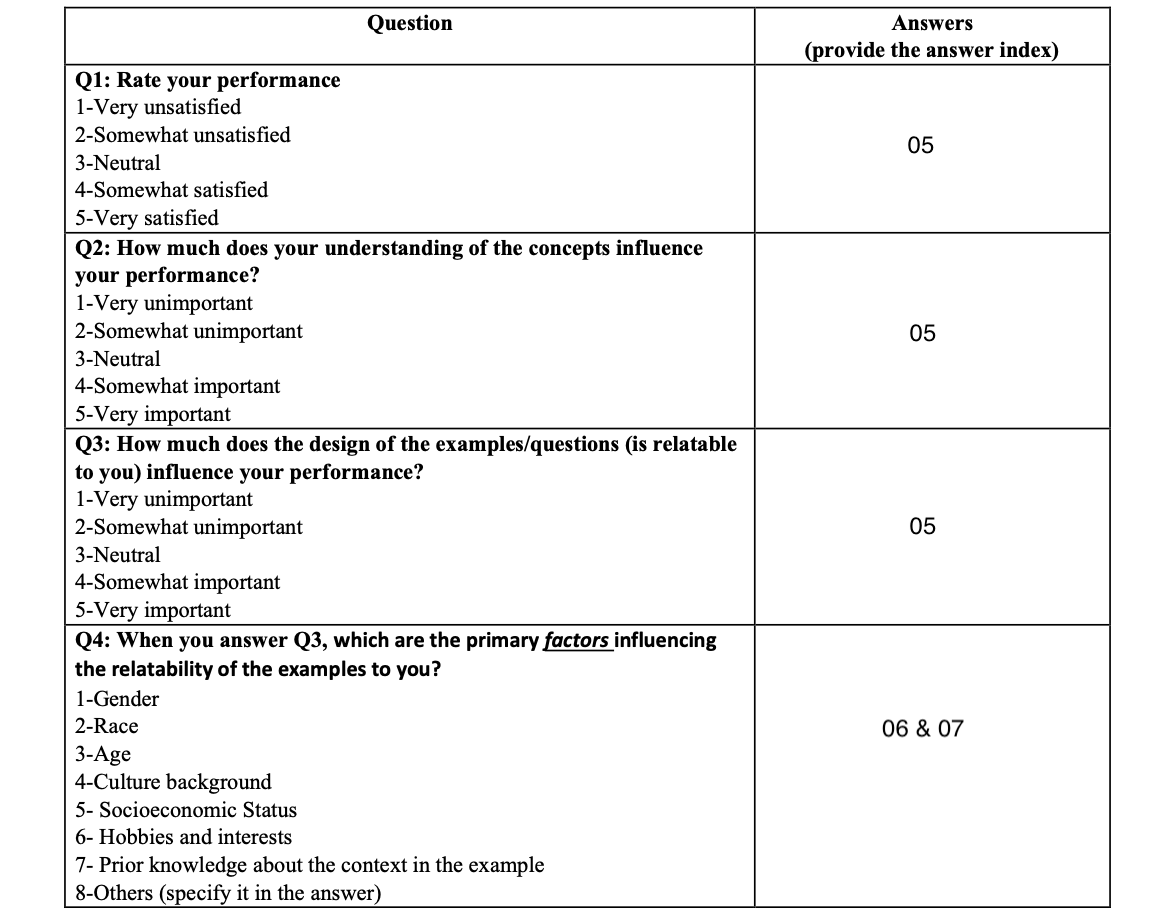


### References
[1] **Rajpurkar, SQuAD v2 Dataset**: The dataset used in this analysis is publicly available on Hugging Face. [SQuAD v2 Dataset](https://huggingface.co/datasets/rajpurkar/squad_v2)  
[2] **Hugging Face Transformers Quickstart**: A guide to using the Hugging Face Transformers library for question-answering tasks. [Hugging Face Transformers Quickstart](https://huggingface.co/docs/transformers/main/en/quicktour)  
[3] **RoBERTa for Question Answering**: Official Hugging Face documentation for the RobertaForQuestionAnswering model. [Hugging Face RoBERTa Documentation](https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaForQuestionAnswering)  
[4] **RoBERTa Model Overview**: Detailed insights into RoBERTa's architecture and capabilities for question-answering tasks. [Hugging Face RoBERTa Overview](https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaForQuestionAnswering)  
[5] **ChatGPT**: Large language model by OpenAI, accessed through its official platform. [ChatGPT Official Website](https://chatgpt.com/)  
[6] **Claude**: Large language model by Anthropic, accessed through its official platform. [Claude AI Official Website](https://claude.ai/new)  